# Almost-scaled dot product attention

_TL;DR: Scaled dot product attention isn't properly scaled, and that's a good thing!_

Transformers seem to be all you need, but we don't fully understand why they work so well. While working on [unit scaling](https://arxiv.org/abs/2303.11257), we noticed something surprising about attention, the heart of the transformer architecture, and how the outputs are scaled.

Many deep learning modules are designed and initialised to roughly preserve variance in the forward and/or backward (gradient) passes. Dot product attention explicitly includes a scaling factor for this ($\sqrt{1/d_{head}}$). But **this is not enough for attention to preserve variance**.

In this notebook, we'll pick apart the variance-scaling behaviour of attention, and propose a new scaling factor. Here's what to expect:

1. [Hey attention, how's scaling?](#1.-Hey-attention,-how's-scaling?)
2. [Attention: flat, spiky or log-normal?](#2.-Attention:-flat,-spiky-or-log-normal?)
3. [Fully scaled dot product self attention](#3.-Fully-scaled-dot-product-attention)
4. [Properly scaled, properly broken](#4.-Properly-scaled,-properly-broken.)
5. [What did I learn?](#5.-What-did-I-learn?)

This is a long-ish, somewhat mathsy article, so if you want to skip to the answer, that's [part 3](#3.-Fully-scaled-dot-product-attention), but make sure you read why you shouldn't use it in [part 4](#4.-Properly-scaled,-properly-broken.) before blaming us.

In [ ]:
# Preamble
%pip install -q einops matplotlib seaborn
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Iterable
sns.set_context("notebook")

---

## 1. Hey attention, how's scaling?

Here's an expression for non-causal scaled dot product [attention](https://arxiv.org/abs/1706.03762) (the core, excluding input and output projections):

$Z = \mathrm{Attention}(Q, K, V) \;\textrm{where}\; \{Q,K,V,Z\} \in \mathcal{R}^{d_{seq} \times d_{head}}$

defined as:

$A^{\prime} = Q K^T \cdot d_{head}^{-1/2}$

$Z = \mathrm{Softmax}(A^{\prime})\, V$

Here $Q$, $K$ and $V$ are _queries_, _keys_ and _values_ derived from the input, $d_{head}$ is the _head size_, and $d_{seq}$ the _sequence length_. We use $A^{\prime}$ for the pre-softmax attention scores matrix. Let's see how well it preserves standard deviation, which we'll refer to as _**scale**_.

In [11]:
d_seq = 256
d_head = 64
n_heads = 2
n_batch = 512

Q, K, V = torch.randn(3, n_batch, n_heads, d_seq, d_head)

A_pr = Q @ K.transpose(2, 3) * (d_head ** -0.5)  # 1. Scaled QK matmul
A = torch.softmax(A_pr, dim=-1)                  # 2. Softmax
Z = A @ V                                        # 3. AV matmul

for name in ["Q", "K", "V", "", "A_pr", "A", "Z"]:
    if not name: print("-"*30); continue
    var = globals()[name]
    print(f"{name:>5}:  μ={var.mean():>6.3f}, σ={var.std():.3f}")

    Q:  μ= 0.000, σ=1.000
    K:  μ=-0.000, σ=1.000
    V:  μ=-0.000, σ=1.000
------------------------------
 A_pr:  μ= 0.000, σ=1.000
    A:  μ= 0.004, σ=0.005
    Z:  μ=-0.000, σ=0.102


This code generates unit-normal inputs $Q, K, V$ to attention, then prints the mean and scale of intermediate and output tensors $A^{\prime}, A \,(=\!\mathrm{Softmax}(A^{\prime})), Z$.

**Step 1 is to compute $Q K^T \cdot d_{head}^{-1/2}$.**

The scaling factor $d_{head}^{-1/2}$ has been carefully chosen to cancel out an increased scale from the sum of uncorrelated values. Since $\mathbb{E}(Q_{ij} K_{kj}) = 0$ and $\mathbb{E}((Q_{ij} K_{kj})^2) = 1$, the central limit theorem gives $\mathbb{E}((Q K^T)^2) = d_{head}$ for large $d_{head}$. To give the output $A^{\prime}$ unit scale, we must multiply by $d_{head}^{-1/2}$.

**Step 2 is softmax over the sequence length.**

The softmax itself cannot preserve unit scale, since the outputs are in the range $[0, 1]$; the highest possible scale would be 1/2. It also cannot ensure zero mean, since it sums to 1 over the target sequence dimension $d_{seq}$, so $\mathbb{E}(A) = d_{seq}^{-1}$.

**Step 3 is to use the attention matrix $A$ to mix the values $V$.**

Following the method of step 1, _if_ the inputs were both zero-mean, unit-scale, we would expect to multiply by $d_{seq}^{-1/2}$ to retain unit scale. However, as we saw in step 2, the $A$ matrix is far from satisfying this assumption. In the example above, this means $Z$ has a low scale ~0.1, so multiplying by $d_{seq}^{-1/2}$ would move it in entirely the wrong direction.

**Summary**

Although scaled dot product attention includes a scaling factor, it does not deal with all of the scaling behaviour: **attention outputs are under-scaled**.

In [14]:
Z.std()

tensor(0.1020)

---

## 2. Attention: flat, spiky or log-normal?

In this section, we'll try to explain why $Z$ is under-scaled in standard attention. We'll first introduce a temperature $t$ into the softmax, as it gives two extreme cases that are a bit simpler to follow, before tackling the more difficult $t=1$ case.

For $X \in \mathcal{R}^{d_{seq}}$, consider $\mathrm{Softmax}(X / t)_i = e^{X_i / t} \,/ \sum_j{e^{X_j/t}}$.

High temperatures flatten the softmax, while low temperatures make it spiky:

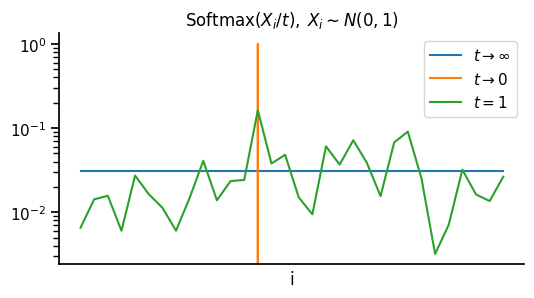

In [5]:
torch.manual_seed(1)
A_pr = torch.randn(32)
plt.figure(figsize=(6, 3))
plt.plot(torch.softmax(A_pr*0, -1), label=r"$t\to \infty$")
plt.plot(torch.softmax(A_pr/1e-3, -1), label=r"$t\to 0$")
plt.plot(torch.softmax(A_pr, -1), label="$t=1$")
sns.despine(); plt.legend(); plt.yscale("log"); plt.xticks([]); plt.xlabel("i")
plt.title(r"$\mathrm{Softmax}(X_i/t),\; X_i\sim N(0, 1)$");


---

**2.1 In the extreme $t\to\infty$**, we get $\mathrm{Softmax}(X/t)_i = d_{seq}^{-1}$, which is a flat distribution over attention keys.

Plugging this into attention, we'd expect $\mathbb{E}((A_{ij} V_{jk})^2) = d_{seq}^{-2}$, so $\mathbb{E}((A V)^2) = d_{seq}^{-1}$.

Overall, we'd expect output scale $d_{seq}^{-1/2}$, i.e.

In [21]:
Zstd_pred = d_seq ** -0.5
print(f"t->∞ predicted scale: {Zstd_pred:.3f} (actual: {Z.std():.3f})")

t->∞ predicted scale: 0.062 (actual: 0.102)


This is quite a close match to what we saw.

---

**2.2 In the extreme $t\to 0$**, we get $\mathrm{Softmax}(X/t)_i = \mathbb{I}(X_i\!==\!\mathrm{Max}(X))$, which is a unit "spike" on the maximum value of $X$. Since $A$ and $V$ are uncorrelated, the matrix multiplication $A V$ then selects a random value from $V$, therefore $\mathbb{E}((A V)^2) = 1$. 

We'd expect output scale $1$.

In [ ]:
Zstd_pred = 1
print(f"t->0 predicted scale: {Zstd_pred:.3f} (actual: {Z.std():.3f})")

t->0 predicted scale: 1.000 (actual: 0.102)



---

**2.3 Otherwise**, start by assuming that the values going into the softmax are normally distributed, with scale $1/t$. Then, rewrite $\mathrm{Softmax}(X)_i = e^{X_i - \log\sum_j{e^{X_j}}}$. Now we treat the log-sum-exp term as a constant, independent of the value of $X$, and will later ensure that the softmax is _normalised in expectation_, so we can say:

$A = e^{A^{\prime\prime}},\; A^{\prime\prime} \sim N(\mu, t^{-2})$

$A$ therefore follows a log-normal distribution, Given the normalisation-in-expectation constraint $\mathbb{E}(A)=d_{seq}^{-1}$, we can solve for the unknown $\mu$, giving:

$A \sim \mathrm{lognormal}(-\ln(d_{seq}) - \frac{1}{2}\, t^{-2}, t^{-2})$.

Since we assume $A$ and $V$ are independent, $\mathbb{E}(A_{ij} V_{jk}) = \mathbb{E}(A)\, \mathbb{E}(V) = 0$.

Also, $\mathbb{E}((A_{ij} V_{jk})^2) = \mathbb{E}(A^2)\, \mathbb{E}(V^2) = e^{2\mu + 2\sigma^2} = d_{seq}^{-2}\,e^{t^{-2}}$, so $\mathbb{E}((A V)^2) = d_{seq}^{-1}\,e^{t^{-2}}$.

This predicts the output scale $(e^{t^{-2}}/d_{seq})^{1/2}$.

In [25]:
Zstd_pred = (torch.e / d_seq) ** 0.5
print(f"t=1 predicted scale: {Zstd_pred:.3f} (actual: {Z.std():.3f})")

t=1 predicted scale: 0.103 (actual: 0.102)


This matches our example very closely!


---

**Quick check**

Now let's see if these rules work for $\mathrm{Softmax}(A^{\prime} V)$ in isolation.

In [28]:
def empirical_softmax_std_scaling(d_seq: int, t: float, nelement: int = int(1e7)) -> float:
    A_pr = torch.randn(nelement // d_seq, d_seq)
    V = torch.randn(nelement // d_seq, d_seq)
    Z = (torch.softmax(A_pr / t, -1) * V).sum(-1)
    return Z.std()

def lognormal_softmax_std_scaling(d_seq: int, t: float) -> float:
    return torch.minimum(torch.tensor(1), d_seq ** -0.5 * torch.exp(t ** -2 / 2))

Hopefully no surprises in the implementation of the above. Let's see how well it predicts the scale as we vary temperature:

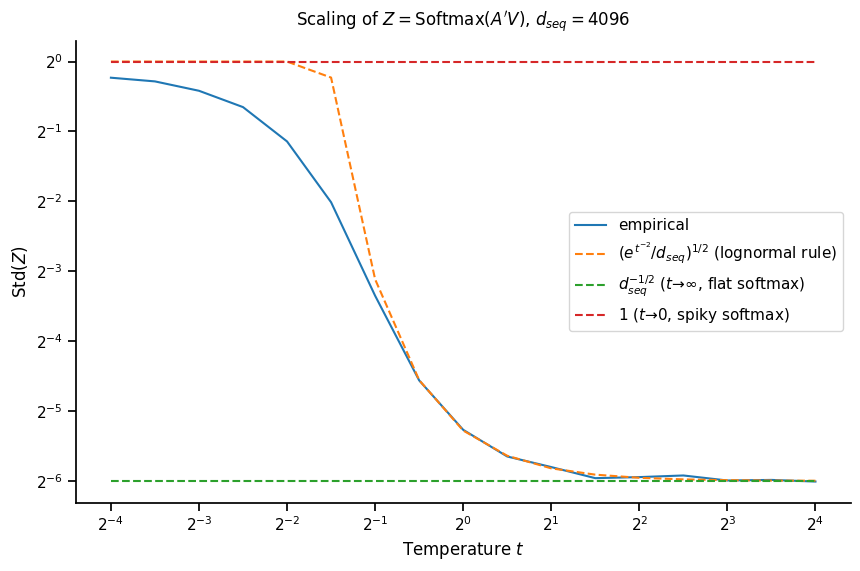

In [33]:
range_t = 2 ** torch.arange(-4, 4.01, 0.5)
d_seq = 4096

empirical_scaling = [empirical_softmax_std_scaling(d_seq=d_seq, t=t) for t in range_t]
lognormal_scaling = lognormal_softmax_std_scaling(d_seq=d_seq, t=range_t)
temperature_inf_scaling = d_seq ** -0.5
temperature_zero_scaling = 1.0

plt.figure(figsize=(10, 6)) ; c = iter(sns.color_palette())
plt.plot(range_t, empirical_scaling, color=next(c), label="empirical")
plt.plot(range_t, lognormal_scaling, color=next(c),
         linestyle="dashed", label="$(e^{t^{-2}}/d_{seq})^{1/2}$ (lognormal rule)")
plt.hlines(temperature_inf_scaling, range_t.min(), range_t.max(),
           color=next(c), linestyle="dashed", label=r"$d_{seq}^{-1/2}$ ($t\to\infty$, flat softmax)")
plt.hlines(temperature_zero_scaling, range_t.min(), range_t.max(),
           color=next(c), linestyle="dashed", label=r"$1$ ($t\to 0$, spiky softmax)")
plt.xscale("log", base=2) ; plt.xticks(2**torch.arange(-4, 4.01)) ; plt.yscale("log", base=2) ; sns.despine()
plt.xlabel("Temperature $t$") ; plt.ylabel(r"$\mathrm{Std}(Z)$")
plt.legend(loc="center right")
plt.title(f"Scaling of $Z = \mathrm{{Softmax}}(A^{{\prime}} V)$, $d_{{seq}}={d_seq}$", pad=10);

That's not too bad. Our $t\to\infty$ and $t\to 0$ rules give the right asymptotes, and the log-normal rule seems to work OK for $t\ge\frac{1}{2}$. We expect the log-normal breakdown is due to the fact that our model only normalises the softmax in expectation, whereas the true softmax normalises over a finite set of samples.

Now we're fully equipped with a scaling model to "fix" attention's forward pass.

---

# 3. Fully scaled dot product attention

We just saw that the pre-softmax scaling of dot product attention works as expected, but that we need to add an additional post-softmax scale factor if we want to prevent scale from shrinking through attention as a whole. Without a scale factor, we expect unit-scaled inputs to produce outputs of scale $(e/d_{seq})^{1/2}$.

To counteract this, we can modify attention, adding a <span style="color: #fc4349">post-scaling factor</span> to give _fully scaled attention_:

$A^{\prime} = Q K^T \cdot d_{head}^{-1/2}$

$Z = \mathrm{Softmax}(A^{\prime})\, V \color{red}{\,\cdot\, (d_{seq}/e)^{1/2}}$

Let's implement & sanity-check:

In [34]:
d_seq = 256
d_head = 64
n_heads = 2
n_batch = 512

Q, K, V = torch.randn(3, n_batch, n_heads, d_seq, d_head)

A_pr = Q @ K.transpose(2, 3) * (d_head ** -0.5)  # 1. Scaled QK matmul
A = torch.softmax(A_pr, dim=-1)                  # 2. Softmax
Z = A @ V * (d_seq / np.e) ** 0.5                # 3. Scaled AV matmul (NEW)

for name in ["Q", "K", "V", "", "A_pr", "A", "Z"]:
    if not name: print("-"*30); continue
    var = globals()[name]
    print(f"{name:>5}:  μ={var.mean():>6.3f}, σ={var.std():.3f}")

    Q:  μ=-0.000, σ=1.000
    K:  μ= 0.000, σ=1.000
    V:  μ= 0.000, σ=1.000
------------------------------
 A_pr:  μ=-0.000, σ=1.000
    A:  μ= 0.004, σ=0.005
    Z:  μ= 0.003, σ=0.994


That's grand—as we hoped, $Z$ is now roughly unit-scale, so we've reached well-scaled attention, hurrah! Note that causal masking and positional encodings may change the scaling behaviour, but we leave these as an exercise for the reader. You can import PyTorch implementations of this & other scaled ops from our [unit-scaling](https://github.com/graphcore-research/unit-scaling) library.

---

# 4. Properly scaled, properly broken.

With great optimism, let's see what happens when we try out our attention scaling "fix" in a full transformer. To keep things quick and simple, we'll train a small autoregressive byte-level transformer model on the works of Shakespeare (much like [nanoGPT](https://github.com/karpathy/nanoGPT)).

We're only interested in training dynamics, not whether this change has an impact on generalisation, so our metric will be final training loss. We'll use a fixed batch size, number of steps and model size, on the assumption that our scaling change should work over similar ranges as the baseline. However, since we have changed the scaling applied to a subset of the model, we will re-sweep learning rate, as the best learning rate may have changed. Note that the code is tucked away inside the companion module `demo_transformer`, feel free to take a look.

The results:

100%|██████████| 5000/5000 [01:46<00:00, 46.73it/s] 


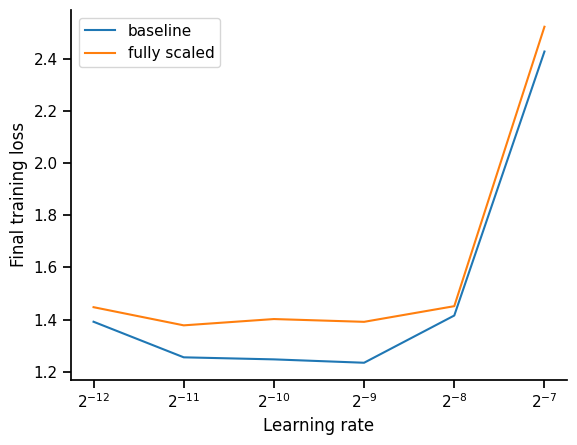

In [2]:
!wget https://www.gutenberg.org/cache/epub/100/pg100.txt -nv -O shakespeare.txt

import demo_transformer

LRS = (2.0 ** -torch.arange(7, 13)).tolist()
def sweep_lr(fully_scaled: bool) -> Iterable[float]:
    demo_transformer.CONFIG.fully_scaled_attention = fully_scaled
    for lr in LRS:
        demo_transformer.CONFIG.lr = lr
        yield float(demo_transformer.train()[-20:].mean())

results = {
    "baseline": list(sweep_lr(fully_scaled=False)),
    "fully scaled": list(sweep_lr(fully_scaled=True)),
}
for name, losses in results.items():
    plt.plot(LRS, losses, label=name)
ax = plt.gca() ; ax.spines["top"].set_visible(False) ; ax.spines["right"].set_visible(False)
ax.legend() ; ax.set_xscale("log", base=2) ; ax.set_xlabel("Learning rate") ; ax.set_ylabel("Final training loss");

Awkwardly, **fully scaled attention seems worse than the original (under-scaled) baseline!**

Note that with fixed sequence length it's always possible for baseline and fully scaled attention to compute the same function (excepting numerical differences). For fully scaled attention, having multiplied by the scale inside attention, it can be divided back out via the trainable parameters in either value or output projection matrices. This indicates that the observed difference is caused by training dynamics or behaviour at initialisation.

We don't yet have an explanation for this difference. Perhaps the higher magnitude of fully scaled attention activations into the residual, or the larger gradients into the residual-split introduce too much noise, or an early saturation of nonlinearities. In any case, it's intriguing that **such a (presumed) accident of under-scaling turns out to be helpful for training dynamics!**

Since unit scaling requires that we get rid of these implicit scaling rules, and keep everything well-scaled, it offers another solution to this problem: to introduce a residual weight when adding the contribution of the attention module to the skip connection from the previous layer. This can be made to have exactly the same effect as the implicit scaling of standard attention, while keeping intermediate tensors close to unit scale, which is great for numerics. (It's also the reason we noticed this interesting property of attention layers in transformer models.)

---

# 5. What did I learn?

We started by asking the question "why doesn't self-attention preserve unit scale", which took us on a (hopefully stimulating) journey via the log-normal distribution to a new definition for _fully scaled dot product attention_. Here it is:

$A^{\prime} = Q K^T \cdot d_{head}^{-1/2}$

$O = \mathrm{Softmax}(A^{\prime})\, V \color{red}{\,\cdot\, (d_{seq}/e)^{1/2}}$

Excitingly, this seemed to do fix variance scaling. Less exciting, but equally interesting: this change seemed to hurt the convergence of an autoregressive transformer model. More work is needed to understand why, but training stability seems to be improved when the weighting of the pointwise FFN layers (in terms of activation std) is larger than that of the attention layers.

We'll leave it there for today; may your transformations preserve scale and may your learning dynamics remain stable. If this has piqued your interest, why not take a look at [unit scaling](https://arxiv.org/abs/2303.11257) (as a special treat, there's even a nice big table of scaling factors in the appendix.)